# Problem Set 2

#### Exercise 1
Write a Matlab function to evaluate the Euler equation in the two period savings
problem discussed in Lecture 4. The function should accept a value for the level of
savings, s, as well as a vector of parameters which dene your problem (e.g.  =
1:1; 
 = 0:5; y1 = y2 = y = 10; r = 0:04) and return the value of the Euler equation at
the given s.

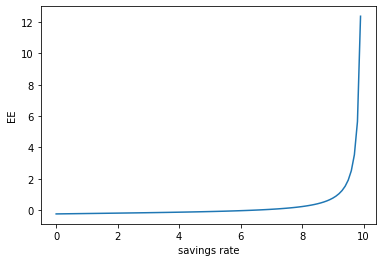

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def euler_equation(s, μ = 1.1, γ = 0.5, y1 = 10, y2 = 10, r = 0.04, β = 1 / (1 + 0.04)):
    return (y1 - s)**(-μ) - (1 + r) * β*(y2 + (1 + r)*s)**(-γ)

# define arguments
s = np.linspace(0, 9.9, 100)

# apply function
ee = euler_equation(s)

# plot
fig, ax = plt.subplots()
ax.plot(s, ee)
ax.set_xlabel('savings rate')
ax.set_ylabel('EE')
plt.show()

#### Exercise 2
Write a program in Matlab to implement the Bisection Method and solve the two
period savings problem discussed in Lecture 4. (You may use fzero or Miranda and
Facklers bisect function to check your work, but try to write your own code for
computing your solution.) Solve the same problem using Newtons method (fsolve)
and compare your results.

In [2]:
# write own bisection function: find s such that euler_equation() evaluates to 0
# recall, s is our choice variable...
def bisection(fun, upper, lower, conv):
    """
    fun is the continuous function for which we´d like to find the root,
    upper is the upper bound of the initial interval,
    lower is the lower bound,
    conv is the convergence criterion which is the desired max distance from the root to its true value
    """
    i = 100000
    while i > conv:
        mid = (upper + lower) / 2
        f_upper, f_lower, f_mid = fun(upper), fun(lower), fun(mid)
        if f_upper > 0 and f_mid < 0:
            lower = mid
        else:
            upper = mid
        i = np.abs(upper - lower)
        
    return mid

In [3]:
# apply
bisection(fun = euler_equation, upper = 9.9, lower = 0, conv = 0.01)

6.409863281250001

In [4]:
# comparing to newton´s method
from scipy.optimize import newton

newton(func = euler_equation, x0 = 5)

6.4078373371133415

#### Exercise 3
Suppose that second period income is stochastic and follows a log normal distribution,
log y2  N(log y; 2), where 2 = 0:5. Create a vector that contains 100 realizations
of y2. (Hint: You may want to use a function like randn.)

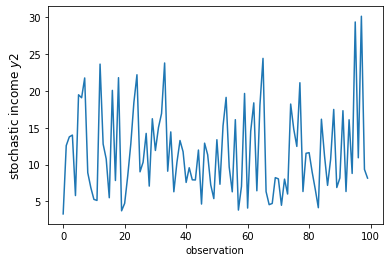

In [5]:
# log normal RVs
y2 = np.random.normal(loc = np.log(10), scale = 0.5, size = 100)

# create y2 from log normal distribution
y2 = np.exp(y2)

fig, ax = plt.subplots()
ax.plot(y2)
ax.set_xlabel('observation')
ax.set_ylabel('stochastic income $y2$', fontsize=12)
plt.show()

#### Exercise 4
Using the solution method of your choice, solve for the optimal savings rate for each
realization of y2 you generated in part 3. Compute the average savings rate.

In [8]:
# define args
μ = 1.1
γ = 0.5
y1 = 10
r = 0.04
β = 1 / (1 + 0.04)

euler_equation = np.vectorize(euler_equation)
roots = []

for i in range(len(y2)):
    y_stochastic = y2[i]
    root = newton(func = euler_equation, x0 = 5, args = (μ, γ, y1, y_stochastic, r, β))
    roots.append(root)
    
mean_savings_rate = np.mean(roots)
mean_savings_rate

6.296467129042242

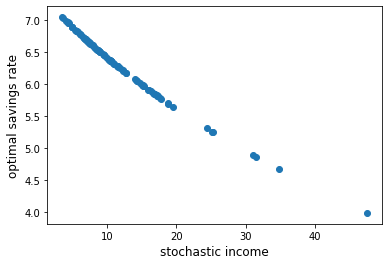

In [9]:
fig, ax = plt.subplots()
ax.scatter(y2, roots)
ax.set_xlabel('stochastic income', fontsize=12)
ax.set_ylabel('optimal savings rate', fontsize = 12)
plt.show()

#### Exercise 5
Write a function in Matlab that accepts a vector of parameters ( = 1:1; 
 = 0:5; y1 =
10; r = 0:04) as well as the vector of realizations of y2 you created in part 3, and a
specied value of s. Given s, your function should return the average value of the Euler
equation in the two period savings problem discussed in lecture 4 for the specied value
of s. (Hint: Your function will need to evaluate the Euler equation for each value of
y2 generated in part 3 and return the average value of the equation for the specied
s.) Use the average savings rate you solved for in part 4 as your specied s. Discuss
your results.

In [10]:
s = mean_savings_rate

def eval_ee(s, y2):
    ee = []
    for i in range(len(y2)):
        output = euler_equation(s = s, y2 = y2[i])
        ee.append(output)
    return np.mean(ee)

print(eval_ee(s = s, y2 = y2), 'is close to 0')

-0.006440240827518666 is close to 0


#### Exercise 6
Consider a similar savings problem where income in the second period is uncertain.
The household maximizes their expected utility over consumption in each period
maxEU(c1; c2)
**...**
where second period income is stochastic, log y2  N(log y; 2). Assume the following
parameter values: **...**

#### (a)
Generate several vectors of di¤ering lengths (100, 1000; and 100000 observations)
that contain realizations of log y2 under the assumption that the variance of log
income is 2 = 0:5.

In [67]:
y2_100 = np.exp(np.random.normal(np.log(10), np.sqrt(0.5), 100))
y2_1000 = np.exp(np.random.normal(np.log(10), np.sqrt(0.5), 1000))
y2_100000 = np.exp(np.random.normal(np.log(10), np.sqrt(0.5), 100000))

#### (b)
Solve for a version of the Euler equation for this expected utility problem and write
a function le that accepts as inputs a level of savings as well as a vector of values
for second period income and the parameters of the problem. Use Monte Carlo
integration for n = [100; 1000; 100000], and the solution algorithm of your choice,
to solve for the expected utility maximizing savings rate. (Hint: Your solution
algorithm should accept a function le which contains the Euler equation that
characterizes your problem, an initial guess for the optimal s, and your vector of
realizations for second period income. It should return the value of s for which the
Euler equation is zero on average.) Discuss the intuition behind how you set up
the expected utility problem. You may want to make reference to your solutions
from parts 4 and 5 in discussing how you chose to set up the problem.

In [68]:
from scipy.optimize import newton

# the EE is now evaluated in expectations!
# we have to evaluate the EE by means of Monte Carlo Integration and subsequently trace out the root by applying the Newton method (or eq.)
class stochastic_EE:
    """
    Implements a stochastic version of the EE by means of Monte Carlo Integration and the Newton method
    
    EE: (y1 - s)**(-μ) - (1+r) * β * E[[y2 + (1 + r)*s]**(-γ)] = 0
    """
    def __init__(self,
                 μ = 1.1, 
                 γ = 0.5,
                 y1 = 10, 
                 y2 = 10, 
                 r = 0.04, 
                 β = 1 / (1 + 0.04)):
        self.μ, self.γ, self.y1, self.y2, self.r, self.β = μ, γ, y1, y2, r, β
    
    def random_part(self, s):
        "Evaluates the random part of the EE and stores the results in an array"
        random = []
        for i in range(len(self.y2)):
            random.append((self.y2[i] + (1 + self.r)*s)**(-self.γ))
        return random
    
    def monte_carlo_integral(self, s):
        "Basically mean of random_part"
        return np.mean(self.random_part(s)) # pass on s here!
    
    def ee(self, s):
        "EE"
        return (self.y1 - s)**(-self.μ) - (1 + self.r) * self.β * self.monte_carlo_integral(s) # pass on s here!
    
    def root_finding(self):
        "Find optimal savings rate s (s.t. EE evaluates to 0)"
        return newton(func = self.ee, x0 = 1)

In [69]:
# n = 100
s_100 = stochastic_EE(y2 = y2_100)
root_100 = s_100.root_finding()

# n = 1000
s_1000 = stochastic_EE(y2 = y2_1000)
root_1000 = s_1000.root_finding()

# n = 100000
s_100000 = stochastic_EE(y2 = y2_100000)
root_100000 = s_100000.root_finding()

print(root_100, root_1000, root_100000)

6.480264116997611 6.401797447317228 6.385974657645666


#### (c)
Compare your solutions for alternative values of n and parameterizations of 2
and CRRA preference parameters (; 
).

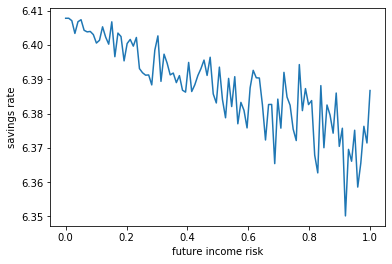

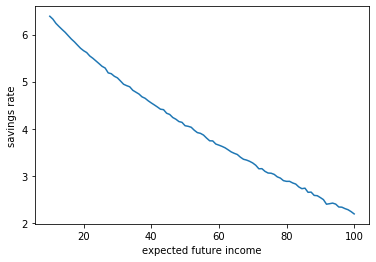

In [87]:
# what happens if future income becomes more risky?
# increase variance in data generating process
σ = np.linspace(0, 1, 100)

risk = []
for i in range(len(σ)):
    future_income = np.exp(np.random.normal(np.log(10), np.sqrt(σ[i]), 10000))
    s = stochastic_EE(y2 = future_income)
    risk.append(s.root_finding())
    
fig, ax = plt.subplots()
ax.plot(σ, risk)
ax.set_xlabel('future income risk')
ax.set_ylabel('savings rate')
plt.show()

# what happens if expectations of feature income increases?
mean = np.linspace(10, 100, 100)

level = []
for i in range(len(mean)):
    future_income = np.exp(np.random.normal(np.log(mean[i]), np.sqrt(0.5), 10000))
    s = stochastic_EE(y2 = future_income)
    level.append(s.root_finding())
    
fig, ax = plt.subplots()
ax.plot(mean, level)
ax.set_xlabel('expected future income')
ax.set_ylabel('savings rate')
plt.show()

Insure against future income risk? Meaning if the RV of feature income has a high uncertainty - this is to say that it is likely to either end up in a very poor or rich state - personally, I would save more in order to prepare for the worst case... But in our model economy, people decrease their savings!